In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss, roc_auc_score

# グラフ描画用
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from plotnine import * 
from plotnine import options
# plotnine 初期設定
options.figure_size = (10, 10)  # サイズ
options.current_theme = theme(
    plot_background=element_rect(fill='white'),
    title=element_text(family='IPAGothic', size=20), # フォント変更
    legend_title=element_text(family='IPAGothic', size=16), # フォント変更
    text=element_text(family='IPAGothic', size=14),
    aspect_ratio=1.0
)

In [2]:
# 実演用データ作成
np.random.seed(42)
n = 1000
# 実際の境界線
logisCurve = lambda x: expit((x - .5) * 10)
# データ
df = pd.DataFrame({'x': np.random.uniform(low=0, high=1, size=n),
                   'y': np.random.uniform(low=0, high=1, size=n)
                  })
df['label'] = logisCurve(df['x']) <= df['y']

# 実験用データと理論上の境界線のプロット

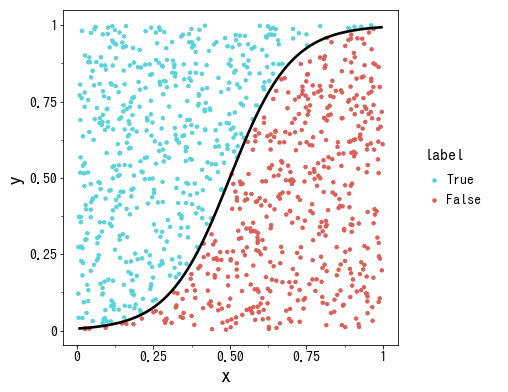

<ggplot: (-9223363275582469344)>


In [3]:
g = ggplot(df) + geom_point(aes(x='x', y='y', color='label'))
g += scale_color_discrete(breaks=[True, False])
g += stat_function(fun=logisCurve, size=1.5)
print(g)

In [4]:
# 計画行列
X = df[['x', 'y']].values
# ラベル
y = df['label'].values

## HotPot アルゴリズム

In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
hotpot = Pipeline([('standardize', StandardScaler()),
                   ('HotPot', SVC(probability=True, random_state=42, kernel='rbf', degree=1))])
hotpot.fit(X, y)

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('HotPot', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))])

## 各アルゴリズムの決定境界プロットと精度の比較

Logistic   log_loss: 0.1675, AUC: 0.9935
GNB        log_loss: 0.2245, AUC: 0.9702
HotPot     log_loss: 0.0529, AUC: 0.9984


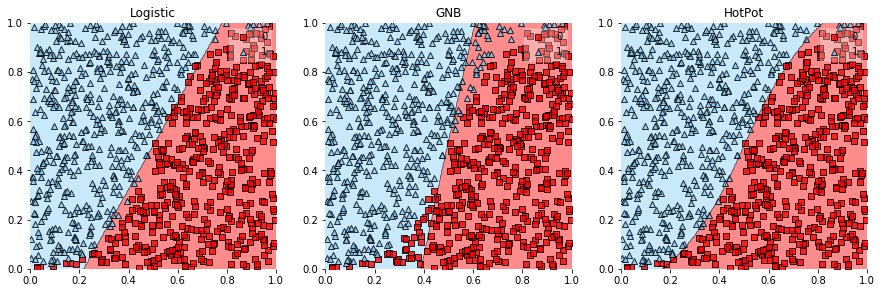

In [6]:
names = ['Logistic', 'GNB', 'HotPot']
models = [
    LogisticRegression(random_state=42, solver='lbfgs'),
    GaussianNB(),
    hotpot
]
fig, ax = plt.subplots(
    nrows=1, ncols=len(models),
    figsize=(5*len(models), 5))
fig.patch.set_facecolor('white')
for i, (name, model) in enumerate(zip(names, models)):
    model.fit(X, y)
    fig = plot_decision_regions(
        X=X,
        y=(y==True)*1,
        clf=model,
        ax=ax[i],
        colors='#FF0000,#87CEFA',
    )
    ax[i].set_aspect('equal', adjustable='box')
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])
    ax[i].set_title(name)
    print('{:10} log_loss: {:.4f}, AUC: {:.4f}'.format(
        name, log_loss(y, model.predict_proba(X)[:, 1]),
        roc_auc_score(y, model.predict_proba(X)[:, 1]))
         )